## Cars196 

[Cars196](http://ai.stanford.edu/~jkrause/cars/car_dataset.html) from Stanford

There are 196 total classes, with a total of 16185 images. The data is roughly split 50-50 between train and test sets

The filename doesn't consist of labels, with just sequential numbering so we'll have to do the proper data shuffling and the appropriate train/valid splits

The labels for each test are provided in a matlab file. For convenience, I have provided them [here](https://github.com/jsaurabh/UB-DL-Meetup/tree/master/lesson1/files). Just download it to the proper directory and you're set to go

In [34]:
from fastai.vision import *
from fastai.metrics import *
import scipy.io as io

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Here, 'cars' is the folder that contains our data. The link provided above contains the dataset but for convenience, we'll download it from Kaggle using the Kaggle API

The dataset is hosted [here](https://www.kaggle.com/jessicali9530/stanford-cars-dataset). There'll be a file called _cars__annos.mat_ but you can go ahead and ignore that as we've already got the pre-processed csv from above

Create the respective directories for train and test, rename them if you want to and move the csv files into the path folder 

I like to have standard names for my train and test folders

In [42]:
path = Path('cars')

In [4]:
train = path/'train'
test = path/'test'

In [5]:
labels = pd.read_csv(path/'anno_train.csv', header=None)
labels.head()

,0,1,2,3,4,5
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


If you've gone through the Stanford link above, the data format should look familiar to you. For each image, there are 5 fields: x1, x2, y1, y2 and target class.

The Cars196 dataset aims to identify the correct bounding boxes for each detected object as well as classifying the given object. For this notebook, we're only interested in image classification so we can go ahead and ignore every field except the target class column

In [6]:
#Assign a separate column to each field associated with an image
labels.columns = ["Image", "x1", "y1", "x2", "y2", "class"];labels.head()

,Image,x1,y1,x2,y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


Drop all unnecessary columns from the dataframe. This will give us a simpler, lossy representation of the original data that is sufficient for the task we're trying to do

__Make sure to only run this cell once__

In [7]:
labels = labels.drop(['x1', 'y1', 'x2', 'y2'], axis=1);

Now, each item in our data has a single field associated with it: the target class. However, we want our network to output the classification as a string value, rather than an encoding. 

Let's grab the names of each target class and create the respective paths in our train folders 

In [8]:
names = pd.read_csv(path/'names.csv', header=None);names.head()

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [9]:
names.columns = ["model"];names.head()

,model
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


Go through the names dataframe and fill in the code segment below

In [10]:
#TO DO
names.model.values[173] = "Ram CV Cargo Van Minivan 2012"

In [11]:
def shuffle_data(len):
    for i in names.model.unique():
        Path.mkdir(train/i, exist_ok=True)
        
    for i in range(len):
        label = names.model.values[i]
        label_imgs = labels.loc[labels['class'] == i+1]
        dst_pth = train/str(label)
        for j in label_imgs.Image.values:
            current_pth = train/j
            os.rename(current_pth, dst_pth/j)

In [12]:
n_len = labels['class'].nunique()
shuffle_data(n_len)

## Now to the fun part!

Define transforms, create a databunch and get started with training CNNs to recognize different models of cars

In [13]:
tfms = get_transforms(do_flip=False, max_lighting=0.2, flip_vert=False, max_zoom=1.1)

Rather than creating a separate split of the training set into a validation set, we'll create what I like to call an implicit validation set

The fastai library will sample a different 20% of the training set during each run of the model as the validation set. This can lead to greater generalizability of your model, rather than a pre-defined validation set split. Note that this will not save the validation set to disk, instead it creates a list pointing to the data items that are to be used as the validation set for a particular run

The items in the valid set can be looked at as follows:
(Data Object).valid_ds

In our case, we'll use *data.valid_ds*

Similar convention can be used to look at the train set

In [39]:
data = ImageDataBunch.from_folder(train, valid_pct = 0.2, ds_tfms = tfms, size=224, bs = 54).normalize(imagenet_stats)

Note that we're only creating a DataBunch from the train set. We'll look at the test set during inference time, predicting the output of the network on headout images and using techniques such as TTA to get an even better model

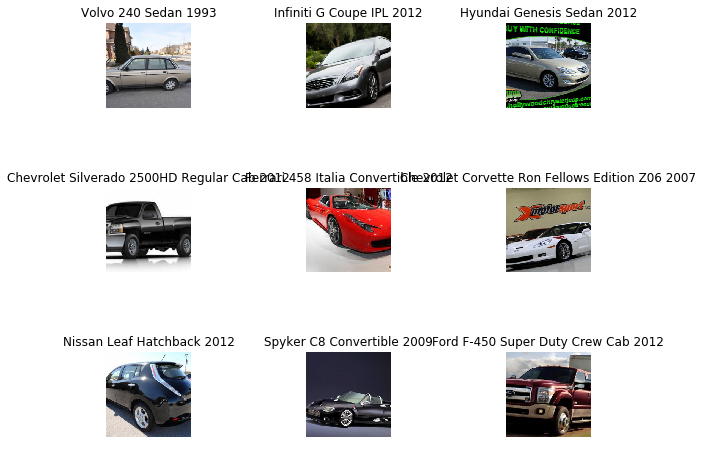

In [40]:
data.show_batch(3, figsize=(9, 7))

Next steps: Create a conv_learner and start training! Use hyper-parameter tuning, lr_finder and other tricks to get the best performing model

In [41]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (6516 items)
[Category BMW 1 Series Convertible 2012, Category BMW 1 Series Convertible 2012, Category BMW 1 Series Convertible 2012, Category BMW 1 Series Convertible 2012, Category BMW 1 Series Convertible 2012]...
Path: cars1/train
x: ImageItemList (6516 items)
[Image (3, 800, 1280), Image (3, 194, 259), Image (3, 580, 800), Image (3, 315, 500), Image (3, 425, 640)]...
Path: cars1/train;

Valid: LabelList
y: CategoryList (1628 items)
[Category Mercedes-Benz SL-Class Coupe 2009, Category Nissan Leaf Hatchback 2012, Category Aston Martin V8 Vantage Convertible 2012, Category Dodge Journey SUV 2012, Category Volvo 240 Sedan 1993]...
Path: cars1/train
x: ImageItemList (1628 items)
[Image (3, 768, 1024), Image (3, 532, 800), Image (3, 264, 390), Image (3, 853, 1280), Image (3, 600, 800)]...
Path: cars1/train;

Test: None

In [23]:
#TO DO

#Conv Learner 
#TTA (https://docs.fast.ai/basic_train.html#TTA)